In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import numpy as np
import pandas as pd
from sklearn import model_selection, svm, preprocessing, metrics, ensemble, tree
import matplotlib.pyplot as plt

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## load  and prepare data

In [3]:
#read in the data with numerical features
data = pd.read_csv('data/transformed_data_num.csv',index_col=0)
data.dropna(inplace=True)

In [4]:
data.head()

,outcometype,animaltype,sex,age,year,neutralized,colormix,breedmix,apricot,black,black.1,blue,blue.1,brindle,brown,buff,calico,chocolate,cream,fawn,flame,gold,gray,lilac,liver,lynx,merle,orange,point,red,sable,seal,silver,smoke,tabby,tan,tick,tiger,torbie,tortie,tricolor,white,yellow,affenpinscher,airedale,akita,alaskan,american,anatol,angora,apso,argentino,australian,basenji,basset,bay,beagle,beauceron,belgian,bernard,bernese,bichon,black.2,black.3,bloodhound,blue.2,blue.3,bluetick,bobtail,border,boston,boxer,brittany,bruss,bull,bulldog,bullmastiff,cairn,cane,cardigan,carolina,catahoula,cattle,cavalier,chesa,chihuahua,chinese,chow,coat,coated,cocker,collie,coon,coonhound,corgi,corso,cur,dachshund,dalmatian,dane,doberman,dog,dogo,domestic,dutch,english,eskimo,feist,finnish,flat,fox,french,frise,german,golden,great,greyhound,griffon,hair,harrier,havanese,heeler,highland,himalayan,hound,husky,inu,irish,italian,jack,japanese,kelpie,labrador,lacy,landseer,leonberger,lhasa,longhair,maine,malamute,malinois,maltese,manchester,manx,mastiff,medium,miniature,mountain,mouth,newfoundland,norfolk,norwich,papillon,parson,patterdale,pbgv,pekingese,pembroke,persian,pharaoh,pinsch,pinscher,pit,plott,pointer,pomeranian,poodle,pug,pyrenees,queensland,ragdoll,rat,redbone,retr,retriever,rhod,ridgeback,rottweiler,rough,russell,russian,schipperke,schnauzer,sharpei,sheepdog,shepherd,shetland,shiba,shih,shorthair,siamese,siberian,silky,smooth,snowshoe,soft,span,spaniel,spitz,springer,st,staffordshire,standard,swedish,terr,terrier,tibetan,toy,treeing,tzu,vallhund,vizsla,walker,weimaraner,welsh,west,wheaten,whippet,wire,wirehair,wolfhound,yorkshire,april,august,december,february,january,july,june,march,may,november,october,september,friday,monday,saturday,sunday,thursday,tuesday,wednesday
AnimalID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Return_to_owner,1.0,0.0,0.090683,0.333333,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Euthanasia,0.0,1.0,0.090683,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.

In [5]:
#prepare data
X = np.array(data.drop('outcometype',axis=1))
Y = np.array(data.outcometype)

Y = Y == 'Adoption' #for binary classification of adoption

x_train, x_test, y_train, y_test = model_selection.train_test_split(X,Y,train_size=0.7)

## support vector classification

In [6]:
#search for a good model
svc = svm.SVC()

gammas = cs = np.array([0.01, 0.1, 1, 10])

param_dict =  {'kernel':['rbf'], 'gamma':gammas, 'C':cs}

clf = model_selection.GridSearchCV(svc, param_grid = param_dict)#, n_jobs=-1)

clf.fit(x_train,y_train)

print(clf.best_score_)
print(clf.best_params_)

results = pd.DataFrame(clf.cv_results_)

results

0.7456446745183463
{'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.640618,0.118343,0.202160,0.055405,0.01,0.01,rbf,"{'C': 0.01, 'gamma': 0.01, 'kernel': 'rbf'}",0.572830,0.572830,0.572830,0.572830,0.572995,0.572863,0.000066,14
1,1.541274,0.033260,0.156489,0.001017,0.01,0.1,rbf,"{'C': 0.01, 'gamma': 0.1, 'kernel': 'rbf'}",0.704067,0.712431,0.699740,0.704644,0.701673,0.704511,0.004330,6
2,1.924117,0.054391,0.180035,0.011050,0.01,1.0,rbf,"{'C': 0.01, 'gamma': 1.0, 'kernel': 'rbf'}",0.572830,0.572830,0.572830,0.572830,0.572995,0.572863,0.000066,14
3,2.735594,0.058159,0.181265,0.012750,0.01,10.0,rbf,"{'C': 0.01, 'gamma': 10.0, 'kernel': 'rbf'}",0.572830,0.572830,0.572830,0.572830,0.572995,0.572863,0.000066,14
4,1.455743,0.115897,0.142210,0.004558,0.1,0.01,rbf,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}",0.701183,0.704355,0.692241,0.693395,0.699077,0.698050,0.004605,7
5,1.367458,0.034716,0.126552,0.008945,0.1,0.1,rbf,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.733199,0.749063,0.719931,0.733487,0.735430,0.734222,0.009247,4
6,1.861752,0.037531,0.175892,0.010601,0.1,1.0,rbf,"{'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}",0.601096,0.601961,0.599942,0.599365,0.597519,0.599977,0.001524,12
7,3.028732,0.086575,0.177011,0.006784,0.1,10.0,rbf,"{'C': 0.1, 'gamma': 10.0, 'kernel': 'rbf'}",0.573118,0.573118,0.573406,0.573406,0.574149,0.573440,0.000377,13
8,1.399014,0.044383,0.120722,0.009184,1.0,0.01,rbf,"{'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'}",0.728007,0.749063,0.720796,0.729161,0.735430,0.732491,0.009500,5
9,1.681897,0.112133,0.126712,0.007584,1.0,0.1,rbf,"{'C': 1.0, 'gamma': 0.1, 'kernel': 'rbf'}",0.742429,0.755408,0.738102,0.741852,0.750433,0.745645,0.006323,1


In [7]:
#training score
clf.score(x_train,y_train)

0.7752394138686973

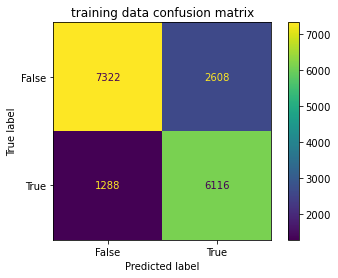

In [8]:
metrics.ConfusionMatrixDisplay.from_estimator(clf,x_train,y_train)
plt.title('training data confusion matrix')
plt.show()

In [9]:
#testing score
clf.score(x_test,y_test)

0.7390309555854644

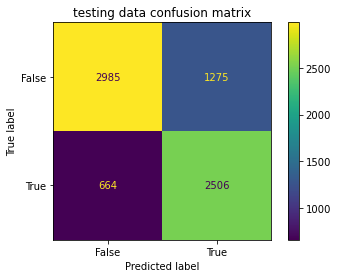

In [10]:
metrics.ConfusionMatrixDisplay.from_estimator(clf,x_test,y_test)
plt.title('testing data confusion matrix')
plt.show()

## random forest

In [61]:
#search a good model
rf = ensemble.RandomForestClassifier()

param_dict = {'max_depth':[10, 20, None], 'criterion':["gini", "entropy"], 'n_estimators':[100], 
              'max_features':['auto', None], 'min_samples_split':[100, 300, 1000], 'min_samples_leaf':[2, 8, 16]}

clf2 = model_selection.GridSearchCV(rf, param_grid = param_dict, n_jobs=-1)

clf2.fit(x_train,y_train)

print(clf2.best_score_)
print(clf2.best_params_)

results = pd.DataFrame(clf2.cv_results_)

results

0.7703938427954211
{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 16, 'min_samples_split': 100, 'n_estimators': 100}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.349727,0.014000,0.182891,0.074061,gini,10,auto,2,100,100,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.760888,0.761754,0.755408,0.763484,0.766301,0.761567,0.003592,70
1,1.948348,0.250038,0.170263,0.057641,gini,10,auto,2,300,100,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.758004,0.763773,0.752235,0.755697,0.759954,0.757933,0.003890,86
2,1.348821,0.013843,0.165892,0.061097,gini,10,auto,2,1000,100,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.754831,0.752812,0.749063,0.753678,0.754761,0.753029,0.002119,94
3,2.178466,0.064025,0.204427,0.072635,gini,10,auto,8,100,100,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.761465,0.770407,0.755985,0.756562,0.771206,0.763125,0.006559,67
4,1.838175,0.157785,0.164911,0.050326,gini,10,auto,8,300,100,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.753966,0.763773,0.754543,0.757139,0.763128,0.758510,0.004178,81
5,1.331476,0.022270,0.155300,0.038822,gini,10,auto,8,1000,100,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.748197,0.751658,0.754254,0.749063,0.755049,0.751644,0.002719,97
6,2.226611,0.068302,0.199972,0.042387,gini,10,auto,16,100,100,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.757427,0.768965,0.755697,0.762042,0.770629,0.762952,0.005985,69
7,1.890917,0.171035,0.184211,0.045793,gini,10,auto,16,300,100,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.758869,0.763773,0.754254,0.755697,0.764282,0.759375,0.004085,74
8,1.265659,0.021353,0.182730,0.013334,gini,10,auto,16,1000,100,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.744448,0.758004,0.740410,0.753678,0.734853,0.746278,0.008492,105
9,9.348833,0.101344,0.215635,0.059075,gini,10,None,2,100,100,"{'criterion': 'gini', 'max_depth': 10, 'max_fe...",0.764638,0.780790,0.760888,0.758869,0.773226,0.767682,0.008193,31


In [62]:
#training score
clf2.score(x_train,y_train)

0.7987192800276912

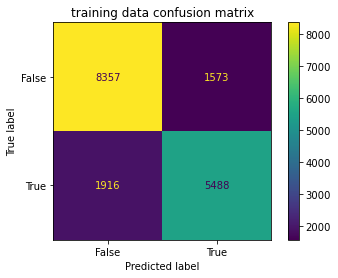

In [63]:
fig,ax = plt.subplots()
metrics.ConfusionMatrixDisplay.from_estimator(clf2,x_train,y_train,ax=ax)
ax.set_title('training data confusion matrix')
#ax.set_xticklabels(labels=['Adoption','Died','Euthanasia','Return to Owner','Transfer'],rotation=30)
plt.show()

In [64]:
#testing score
clf2.score(x_test,y_test)

0.7635262449528937

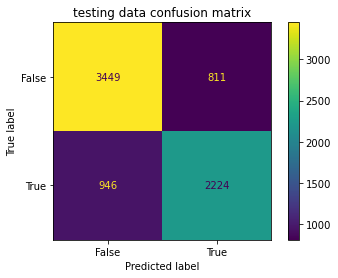

In [65]:
fig,ax = plt.subplots()
metrics.ConfusionMatrixDisplay.from_estimator(clf2,x_test,y_test,ax=ax)
ax.set_title('testing data confusion matrix')
#ax.set_xticklabels(labels=['Adoption','Died','Euthanasia','Return to Owner','Transfer'],rotation=30)
plt.show()

## decision tree

In [130]:
#search a good model
tr = tree.DecisionTreeClassifier()

param_dict = {'max_depth':[10], 'criterion':["gini", "entropy"], 'max_features':['auto', None], 
              'min_samples_split':[100, 300, 1000], 'splitter':['best', 'random'], 'min_samples_leaf':[4, 16, 64], 
             'ccp_alpha':[0, 1e-7, 1e-5, 1e-3]}

clf3 = model_selection.GridSearchCV(tr, param_grid = param_dict, n_jobs = -1)

clf3.fit(x_train,y_train)

print(clf3.best_score_)
print(clf3.best_params_)

results = pd.DataFrame(clf3.cv_results_)

results

0.7656057084927861
{'ccp_alpha': 1e-05, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 16, 'min_samples_split': 300, 'splitter': 'random'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ccp_alpha,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.154192,0.003787,0.006519,0.000582,0,gini,10,auto,4,100,best,"{'ccp_alpha': 0, 'criterion': 'gini', 'max_dep...",0.704644,0.674358,0.653303,0.593308,0.624639,0.650050,0.038593,193
1,0.154342,0.006941,0.009577,0.003593,0,gini,10,auto,4,100,random,"{'ccp_alpha': 0, 'criterion': 'gini', 'max_dep...",0.673781,0.643207,0.689068,0.601384,0.597230,0.640934,0.037082,212
2,0.179329,0.010608,0.006078,0.000853,0,gini,10,auto,4,300,best,"{'ccp_alpha': 0, 'criterion': 'gini', 'max_dep...",0.587828,0.580040,0.685607,0.573695,0.613387,0.608112,0.041030,280
3,0.156648,0.012033,0.005800,0.000516,0,gini,10,auto,4,300,random,"{'ccp_alpha': 0, 'criterion': 'gini', 'max_dep...",0.700606,0.688203,0.611191,0.674935,0.606174,0.656222,0.039687,183
4,0.150537,0.006022,0.006427,0.001665,0,gini,10,auto,4,1000,best,"{'ccp_alpha': 0, 'criterion': 'gini', 'max_dep...",0.613210,0.694837,0.578310,0.631382,0.645124,0.632573,0.038354,234
5,0.146783,0.005374,0.008168,0.002433,0,gini,10,auto,4,1000,random,"{'ccp_alpha': 0, 'criterion': 'gini', 'max_dep...",0.614652,0.690511,0.691953,0.637150,0.586844,0.644222,0.041563,205
6,0.138255,0.013020,0.005842,0.000755,0,gini,10,auto,16,100,best,"{'ccp_alpha': 0, 'criterion': 'gini', 'max_dep...",0.651284,0.682146,0.678685,0.721373,0.618580,0.670414,0.034221,159
7,0.138703,0.003404,0.005831,0.000771,0,gini,10,auto,16,100,random,"{'ccp_alpha': 0, 'criterion': 'gini', 'max_dep...",0.675800,0.663975,0.672339,0.668878,0.602712,0.656741,0.027296,182
8,0.140948,0.007935,0.006666,0.000767,0,gini,10,auto,16,300,best,"{'ccp_alpha': 0, 'criterion': 'gini', 'max_dep...",0.756273,0.577733,0.575425,0.740121,0.707732,0.671457,0.079033,157
9,0.153781,0.015818,0.008767,0.002362,0,gini,10,auto,16,300,random,"{'ccp_alpha': 0, 'criterion': 'gini', 'max_dep...",0.637150,0.581771,0.652149,0.619267,0.649740,0.628016,0.025896,250


In [131]:
#training score
clf3.score(x_train,y_train)

0.7686050536517827

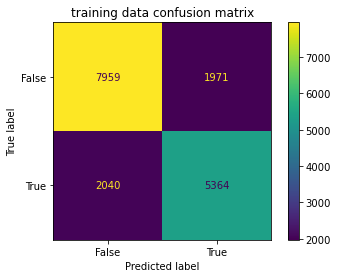

In [132]:
fig,ax = plt.subplots()
metrics.ConfusionMatrixDisplay.from_estimator(clf3,x_train,y_train,ax=ax)
ax.set_title('training data confusion matrix')
#ax.set_xticklabels(labels=['Adoption','Died','Euthanasia','Return to Owner','Transfer'],rotation=30)
plt.show()

In [133]:
#testing score
clf3.score(x_test,y_test)

0.7639300134589502

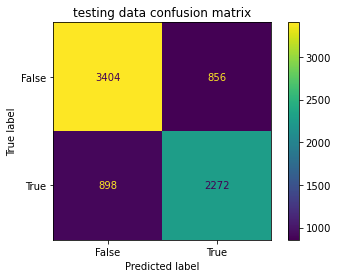

In [134]:
fig,ax = plt.subplots()
metrics.ConfusionMatrixDisplay.from_estimator(clf3,x_test,y_test,ax=ax)
ax.set_title('testing data confusion matrix')
#ax.set_xticklabels(labels=['Adoption','Died','Euthanasia','Return to Owner','Transfer'],rotation=30)
plt.show()

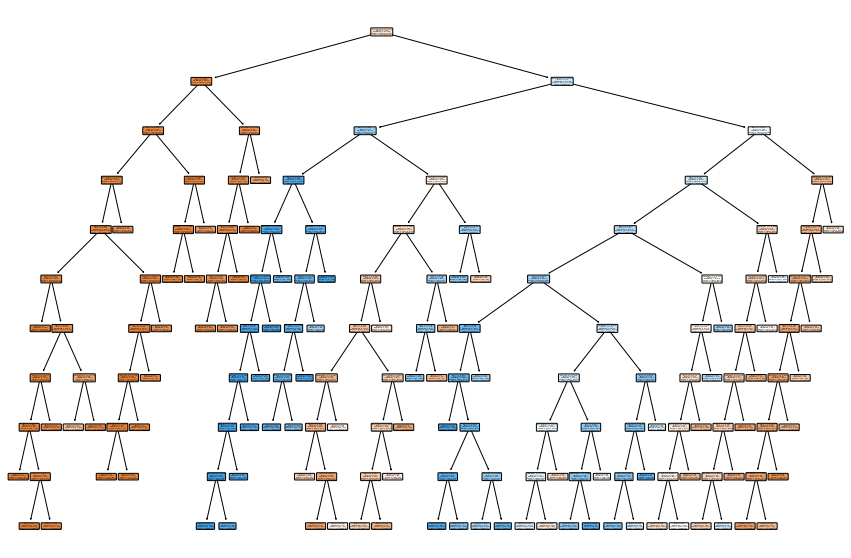

In [135]:
fig = plt.figure(figsize=(15,10))
tree.plot_tree(clf3.best_estimator_,feature_names=data.columns[1:] ,rounded=True, filled =True, 
               class_names=['no adoption', 'adoption'])
plt.show()
#fig.savefig('tree.pdf')